In [1]:
from squlearn.encoding_circuit.encoding_circuit_derivatives import *
from squlearn.util import Executor
from qiskit.primitives import Estimator, Sampler
from squlearn.kernel.matrix import FidelityKernel, ProjectedQuantumKernel
from scipy.optimize import minimize
from squlearn.encoding_circuit import *
import numpy as np
from matplotlib import pyplot as plt

from squlearn.observables import *
from circuits.circuits import *
from squlearn.qnn.qnn import QNN

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:

def rbf_fun(x,y,sigma=1):
    return np.exp(-(x-y)**2/(2*sigma**2))

def rbf_kernel_manual(x, y, sigma=1):
    kernel = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            kernel[i, j] = rbf_fun(x[i], y[j], sigma)
    return kernel

def analytical_derivative_rbf_kernel(x, y, sigma=1):
    derivative = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            derivative[i, j] = -rbf_fun(x[i], y[j], sigma) * (2*(x[i]-y[j])/(2*sigma**2))
    return derivative


In [34]:
def f_alpha_0(alpha_, kernel_order_0):
    """
    f_alpha_0 =  f(x_span) = b + K(x_span, x_span) @ alpha
    Parameters:
    - alpha: The vector of alphas, of shape (len(x_span)+1, 1).
    - kernel_tensor: a
    - initial_conditions: Initial values for the dependent variables.
    Returns:
    - f_alphas: The vector of f_alphas, of shape (len(x_span), 1).
    """
    b = alpha_[0]
    alpha = alpha_[1:]
    return b + kernel_order_0 @ alpha

def f_alpha_1(alpha_, kernel_order_1):
    """
    f_alpha_1 =  df/dx(x_span) =   K(x_span, x_span) @ alpha

    Parameters:
    - alpha: The vector of alphas, of shape (len(x_span)+1, 1).
    - kernel_tensor: a
    - initial_conditions: Initial values for the dependent variables.
    Returns:
    - f_alphas: The vector of f_alphas, of shape (len(x_span), 1). of the first order derivative
    """
    alpha = alpha_[1:]
    return  kernel_order_1 @ alpha
def g(f, x):
    lamb  = 20
    k = 0.1
    return -lamb*np.exp(-lamb*x*k)*np.sin(lamb*x) - lamb*k*f

def loss_function(alpha_, f_initial,regularization_parameter, x_span, kernel_order_0, kernel_order_1):
    """
    The loss function to be minimized.

    L(alpha) = (f_alpha(x_span) - g(f_alpha(x_span)))^2 + (f_alpha(0) - f_initial)^2

    Where f_alpha(x_span) = b + K(x_span, x_span) @ alpha

    Parameters:
    - alpha: The vector of alphas, of shape (len(x_span)+1, 1).
    - f_initial: The initial value of the dependent variable.
    - regularization_parameter: The regularization parameter. In the paper this was not used. Default should be 1
    - x_span: The span of the independent variable.
    - kernel_tensor: The kernel tensor.

    Returns:
    - L: The loss value.
    """

    alpha = alpha_#[1:]
    sum1 = np.sum((f_alpha_1(alpha, kernel_order_1)-g(f_alpha_0(alpha, kernel_order_0), x_span))**2)
    sum2 = (f_alpha_0(alpha, kernel_order_0)[0]-f_initial)**2
    L =  sum2 + sum1*regularization_parameter
    return L


def solve(x_span, kernel_tensor, loss_function, f_initial):
    """
    Solve the differential equation using the specified method.

    Parameters:
    - x_span: The span of the independent variable.
    - kernel_tensor: The kernel tensor.
    - loss_function: The loss function.
    - f_initial: The initial value of the dependent variable.


    Returns:
    - solution: The solution of the differential equation.
    """
    # Get the kernel object
    
    regularization_parameter = 1
    alpha_0 = np.ones(len(x_span)+1)
    result = minimize(loss_function, alpha_0, 
                args = (f_initial, regularization_parameter, x_span, kernel_tensor[0], kernel_tensor[1]),
                options={'disp': True, 'maxiter':10000})

    optimal_alpha = result.x #optimal_alpha = [b, alpha_1, alpha_2, ...]
    # Evaluate the solution
    solution = f_alpha_0(optimal_alpha, kernel_tensor[0])
    
    
    return solution, optimal_alpha

In [31]:
def P0_squlearn(num_qubits):
    """
    Create the P0 observable: (|0><0|)^\otimes n for the quantum circuit in the format of the squlearn library. 
    Note that |0><0| = 0.5*(I + Z) 

    Parameters:
    num_qubits: int, the number of qubits in the quantum circuit.

    return:
    - CustomObservable: The P0 observable in the format of the squlearn library.
    - coefficients: The coefficients of the P0 observable to be used in the QNN squlearn evaluation

    """
    from qiskit.quantum_info import SparsePauliOp
    
    P0_single_qubit = SparsePauliOp.from_list([("Z", 0.5), ("I", 0.5)])
    P0_temp = P0_single_qubit
    for i in range(1, num_qubits):
        P0_temp = P0_temp.expand(P0_single_qubit)
    observable_tuple_list = P0_temp.to_list()
    pauli_str = [observable[0] for observable in observable_tuple_list]    
    coefficients = [observable[1] for observable in observable_tuple_list]


    return CustomObservable(num_qubits, pauli_str, parameterized=True), coefficients
    
def x_to_circuit_format_manual(x):
    """
    x: np.array of shape (n, m) where n is the number of samples and m is the number of features.

    Convert the input data to the format that the quantum circuit can accept.
    return: 
    
    np.array of shape (n*n, 2*m) where n is the number of samples and m is the number of features.
    """    
    x_list_circuit_format = np.zeros((len(x)*len(x), 2*len(x[0])))
    gram_matrix_indices = np.zeros((len(x), len(x)))

    for i in range(len(x)):
        for j in range(len(x)):
            gram_matrix_indices[i, j] = i*len(x)+j
            x_list_circuit_format[i*len(x)+j] = np.concatenate((x[i], x[j]))
    return x_list_circuit_format, gram_matrix_indices

def x_to_circuit_format(x):
    """
    x: np.array of shape (n, m) where n is the number of samples and m is the number of features.

    Convert the input data to the format that the program can accept.
    return: np.array of shape (n*n, 2*m) where n is the number of samples and m is the number of features.

    Note, this is necessary because of the way the quantum circuit for FQK is constructed.
    Example: 
    Take x = np.array([[1], 
                        [2], 
                        [3]])
    
    Then, the FQK circuit implements U(x) U^dag(x') |0> = |f(x, x')> |0> 

    Thus, we need to artificially create the input data with all possible x combinations in the format of x and x'.
    """    
    n, m = x.shape
    x_list_circuit_format = np.zeros((n*n, 2*m))

    # Use broadcasting to concatenate the features directly
    x_list_circuit_format[:, :m] = x.repeat(n, axis=0)
    x_list_circuit_format[:, m:] = np.tile(x, (n, 1))
    
    return x_list_circuit_format


def FQK_QNN(EncodingCircuit, num_qubits, executor, **kwargs):
    """
    Create the FQK QNN for the given encoding circuit and the executor.

    Parameters:
    - EncodingCircuit: The encoding circuit to be used. EncodingCircuit should be in qiskit format, not squlearn format!
    - num_qubits: The number of qubits in the quantum circuit.
    - executor: The executor to be used.
    - **kwargs: The additional parameters to be passed to the encoding circuit.

    Returns:
    - qnn_: The FQK QNN.
    - P0_coef: The coefficients of the P0 observable to be used in the QNN squlearn evaluation
    """
    FQK_Circuit = QiskitEncodingCircuit(FQK_kernel_circuit(EncodingCircuit, num_qubits, only_one_variable = True, **kwargs))
    #Create P0 observable
    P0_, P0_coef = P0_squlearn(num_qubits)
    qnn_ = QNN(FQK_Circuit, P0_, executor, result_caching=False, optree_caching=False)
    return qnn_, P0_coef

def PQK_QNN(EncodingCircuit, num_qubits, executor, **kwargs):
    """
    Create the PQK QNN for the given encoding circuit and the executor.

    Parameters:
    - EncodingCircuit: The encoding circuit to be used. EncodingCircuit should be in qiskit format, not squlearn format!
    - num_qubits: The number of qubits in the quantum circuit.
    - executor: The executor to be used.
    - **kwargs: The additional parameters to be passed to the encoding circuit.

    Returns:
    - qnn_: The PQK QNN.
    - observable_coef: The coefficients of the observable to be used in the QNN squlearn evaluation

    """
    PQK_Circuit = QiskitEncodingCircuit(EncodingCircuit(num_qubits = num_qubits, only_one_variable = True, **kwargs))
    
    observable = SummedPaulis(num_qubits, op_str="XYZ", include_identity=False, full_sum=False) #i.e Summed Paulis for a 2 qubit system: IX, XI, IY, YI, IZ, ZI
    observable.get_pauli_mapped([1 for i in range(observable.num_parameters)]) #
    observable_coef = [1 for i in range(observable.num_parameters)]
    qnn_ = QNN(PQK_Circuit, observable, executor, result_caching=False, optree_caching=False)
    return qnn_, observable_coef

def get_FQK_kernel_derivatives(x_array, qnn_, coef):
    """
    Get the FQK kernel and its derivatives for the given input data.

    Parameters:
    - x_array: The input data. np.array of shape (n, m) where n is the number of samples and m is the number of features.
    - qnn_: The FQK QNN.
    - coef: The coefficients of the P0 observable to be used in the QNN squlearn evaluation

    Returns:
    - output_f: The FQK kernel.
    - output_dfdx: The derivatives of the FQK kernel:  shape (n, n, m*2),  the last dimension is the derivative with respect to the input data. 
    """
    

    x_list_circuit_format = x_to_circuit_format(x_array)
    output_f = qnn_.evaluate("f", x_list_circuit_format, [], coef)["f"]
    print("output_f calculated")
    output_dfdx = qnn_.evaluate("dfdx", x_list_circuit_format, [], coef)["dfdx"]
    

    #reshape the output to the shape of the gram matrix
    output_f = output_f.reshape((len(x_array), len(x_array)))
    output_dfdx = output_dfdx.reshape((len(x_array), len(x_array), len(x_array[0])*2))

    return output_f, output_dfdx




def get_PQK_kernel_derivatives(x_array, qnn_, coef, envelope, analytical_derivative, **kwargs):
    """
    Get the PQK kernel and its derivatives for the given input data.

    Parameters:
    - x_array: The input data. np.array of shape (n) where n is the number of samples. m dimensional input is not supported for PQK yet.
    - qnn_: The PQK QNN.
    - coef: The coefficients of the observable to be used in the QNN squlearn evaluation
    - envelope: The envelope function to be used.
    - analytical_derivative: The analytical derivative function to be used.
    - **kwargs: The additional parameters to be passed to the envelope and analytical_derivative functions.

    Returns:
    - output_f_gramm_matrix: The PQK kernel.
    - output_dfdx_gramm_matrix: The derivatives of the PQK kernel. 
    """

    x_list_circuit_format = x_array
    output_f_column = qnn_.evaluate("f", x_list_circuit_format, [], coef)["f"]  #shape (n, 1)    #to be checked
    output_dfdx_qnn_column = qnn_.evaluate("dfdx", x_list_circuit_format, [], coef)["dfdx"] #shape (n, 1) #to be checked
    
    output_f_gramm_matrix = envelope(output_f_column, output_f_column, **kwargs).reshape((len(x_array), len(x_array))) #shape (n, n)

    output_dfdx_gramm_matrix = analytical_derivative(output_f_column, output_f_column, **kwargs) * output_dfdx_qnn_column #shape (n, n, m) #to be checked


    return output_f_gramm_matrix, output_dfdx_gramm_matrix




In [25]:
def f_analytical_fun(x):
    """Analytical solution of the ODE from the paper

    """
    lamb  = 20
    k = 0.1
    return np.exp(-lamb*x*k)*np.cos(lamb*x)

C:\Users\jsl-rf\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


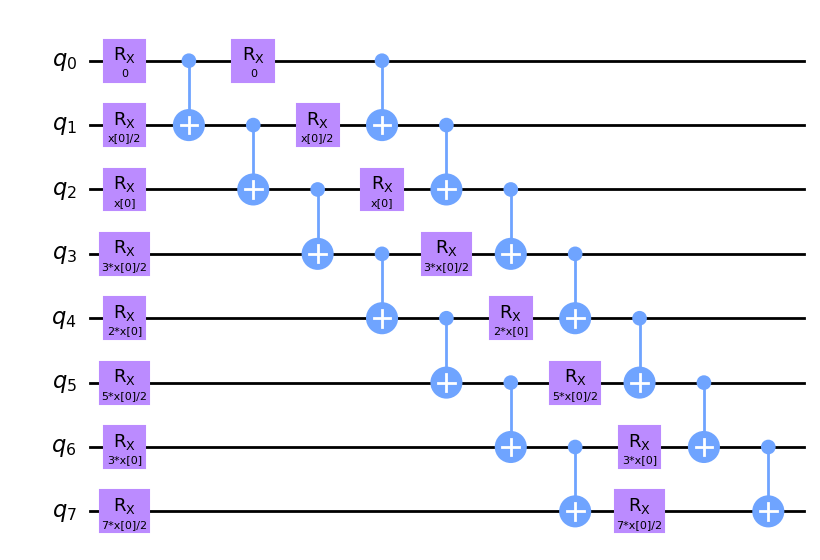

In [26]:
HardwareEfficientEmbeddingCircuit_qiskit(8, 2, "rx", only_one_variable=True).draw("mpl")

In [8]:
num_qubits = 8

x_span = np.linspace(0, 1, 20)
x_span = x_span.reshape(-1, 1)
PQK_qnn, obs_coef = PQK_QNN(HardwareEfficientEmbeddingCircuit_qiskit, num_qubits = num_qubits, executor= Executor("statevector_simulator"), num_layers=2, rotation_gate="rx") 
#Other example: #FQK_qnn, P0_coef = FQK_QNN(Hamiltonian_time_evolution_encoding_qiskit, num_qubits = 3, executor= Executor("statevector_simulator"), trotter_time_T =2, evolve_time_t = 0.5)
K_f, K_dfdx = get_PQK_kernel_derivatives(x_span, PQK_qnn, obs_coef, rbf_kernel_manual, analytical_derivative_rbf_kernel, sigma=0.1)

In [21]:
num_qubits = 8

x_span = np.linspace(0, 1, 20)
x_span = x_span.reshape(-1, 1)

FQK_qnn, P0_coef = FQK_QNN(HardwareEfficientEmbeddingCircuit_qiskit, num_qubits = num_qubits, executor= Executor("statevector_simulator"), num_layers=2, rotation_gate="rx") 
#K_f, K_dfdx = get_FQK_kernel_derivatives(x_span, FQK_qnn, P0_coef)

In [35]:
def classical_solvers(num_points, return_kernel = False, sigma = 0.1, f_initial = 1):
    """
    Solve the ODE using the classical solvers.

    -odeint corresponds to the numerical solution using the odeint method.
    -analytical corresponds to the analytical solution of the ODE.
    -RBF corresponds to the solution using the RBF kernel

    Parameters:
    - num_points: The number of points to be used in the numerical solution.
    - return_kernel: If True, return the kernel as well.
    - sigma: The sigma parameter to be used in the RBF kernel.
    - f_initial: The initial value of the dependent variable.

    Returns:
    - f_odeint: The numerical solution using the odeint method.
    - f_analytical_sol: The analytical solution of the ODE.
    - RBF_sol: The solution using the RBF kernel.
    - kernel_list: The kernel list if return_kernel is True.

    """
    ###Numerical Odeint
    x_span = np.linspace(0, 1, num_points)
    f_odeint = odeint(g, f_initial, x_span[:])
    ### Analytical
    f_analytical_sol = f_analytical_fun(x_span)
    ### RBF
    K_f = rbf_kernel_manual(x_span, x_span, sigma)
    K_dfdx = analytical_derivative_rbf_kernel(x_span, x_span, sigma)
    kernel_list = np.array([K_f, K_dfdx])
    solution, optimal_alpha = solve(x_span, kernel_list, loss_function, f_initial)
    RBF_sol = solution

    if return_kernel:
        return f_odeint, f_analytical_sol, RBF_sol, kernel_list
    return f_odeint, f_analytical_sol, RBF_sol

def FQK_solver(Circuit_qiskit, num_points, num_qubits, f_initial):
    """
    Solve the ODE using the FQK solver.

    First, the FQK QNN is created using the given quantum circuit. Then, the kernel and its derivatives are calculated using the QNN. Finally, 
    the ODE is solved using the FQK solver. i.e the loss function is minimized to find the optimal alpha.

    Parameters:
    - Circuit_qiskit: The quantum circuit to be used.
    - num_points: The number of points to be used in the numerical solution.
    - num_qubits: The number of qubits in the quantum circuit.
    - f_initial: The initial value of the dependent variable.

    Returns:
    - FQK_sol: The solution using the FQK solver.
    - kernel_list: The kernel list.
    """

    x_span = np.linspace(0, 1, num_points)
    FQK_qnn, P0_coef = FQK_QNN(Circuit_qiskit, num_qubits = num_qubits, executor= Executor("statevector_simulator"), num_layers=2, rotation_gate="rx")
    K_f, K_dfdx = get_FQK_kernel_derivatives(x_span.reshape(-1, 1), FQK_qnn, P0_coef)
    kernel_list = np.array([K_f, K_dfdx[:,:,0]])
    solution, optimal_alpha = solve(x_span, kernel_list, loss_function, f_initial)
    FQK_sol = solution
    return FQK_sol, kernel_list

def PQK_solver(Circuit_qiskit, num_points, num_qubits, sigma, f_initial):
    """
    Solve the ODE using the PQK solver.

    First, the PQK QNN is created using the given quantum circuit. Then, the kernel and its derivatives are calculated using the QNN. Finally,
    the ODE is solved using the PQK solver. i.e the loss function is minimized to find the optimal alpha.

    Parameters:
    - Circuit_qiskit: The quantum circuit to be used.
    - num_points: The number of points to be used in the numerical solution.
    - num_qubits: The number of qubits in the quantum circuit.
    - sigma: The sigma parameter to be used in the RBF kernel.

    Returns:
    - PQK_sol: The solution using the PQK solver.
    - kernel_list: The kernel list.
    """
    x_span = np.linspace(0, 1, num_points)
    #x_span = x_span.reshape(-1, 1)

    ### PQK
    PQK_qnn, obs_coef = PQK_QNN(Circuit_qiskit, num_qubits = num_qubits, executor= Executor("statevector_simulator"), num_layers=2, rotation_gate="rx") 
    K_f, K_dfdx = get_PQK_kernel_derivatives(x_span, PQK_qnn, obs_coef, rbf_kernel_manual, analytical_derivative_rbf_kernel, sigma=sigma)
    kernel_list = np.array([K_f, K_dfdx])
    solution, optimal_alpha = solve(x_span, kernel_list, loss_function, f_initial)
    PQK_sol = solution
    return PQK_sol, kernel_list

In [28]:
def eigendecomposition(K):
    """Returns ordered eigenvalues and normalized eigenvectors of a kernel matrix."""
    eigenvalue_spectrum, eigenvectors = np.linalg.eigh(1/K.shape[0] * K)
    inds_sort = np.argsort(eigenvalue_spectrum)
    inds_sort = inds_sort[::-1]
    eigenvalue_spectrum = eigenvalue_spectrum[inds_sort]
    eigenvectors = eigenvectors[:,inds_sort]
    return eigenvalue_spectrum, eigenvectors

def f_analytical(x):
    lamb  = 20
    k = 0.1
    return np.exp(-lamb*x*k)*np.cos(lamb*x)


In [36]:
x_span = np.linspace(0, 1, 21)
odeint_sol, analytical_sol, RBF_sol, RBF_kernel_list = classical_solvers(21, return_kernel = True, sigma = 0.1)

Optimization terminated successfully.
         Current function value: 0.000376
         Iterations: 116
         Function evaluations: 3427
         Gradient evaluations: 149


In [39]:
FQK_sol, FQK_kernel = FQK_solver(HardwareEfficientEmbeddingCircuit_qiskit, 21, 8, 1)

output_f calculated
         Current function value: 0.025224
         Iterations: 82
         Function evaluations: 3140
         Gradient evaluations: 136


In [37]:
PQK_sol, PQK_kernel_list = PQK_solver(HardwareEfficientEmbeddingCircuit_qiskit, 21, 8, 1, 1)

         Current function value: 53.049342
         Iterations: 123
         Function evaluations: 5693
         Gradient evaluations: 247


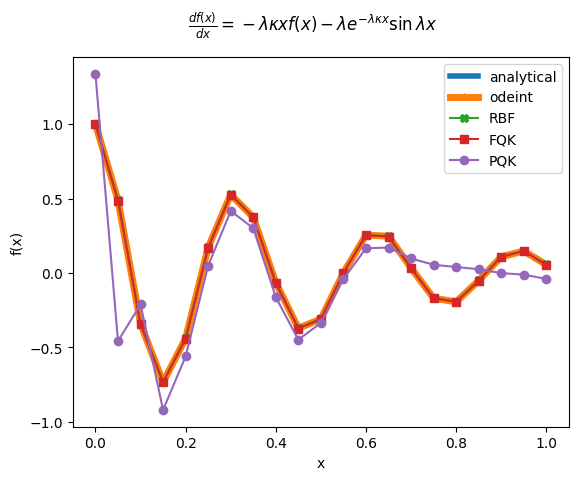

In [40]:
plt.suptitle(r'$\frac{df(x)}{dx} = - \lambda \kappa x f(x) - \lambda e^{-\lambda \kappa x} \sin{\lambda x}$')
plt.plot(x_span, analytical_sol, "-", label = "analytical", linewidth = 4, c= f"C{0}")
plt.plot(x_span, odeint_sol, "*-", label = "odeint", c= f"C{1}", linewidth = 5)
plt.plot(x_span, RBF_sol, "X-",label = "RBF", c= f"C{2}" )
plt.plot(x_span, FQK_sol,"s-", label = "FQK", c= f"C{3}")
plt.plot(x_span, PQK_sol, "o-", label = "PQK", c= f"C{4}")

plt.ylabel("f(x)")
plt.xlabel("x")

plt.legend()

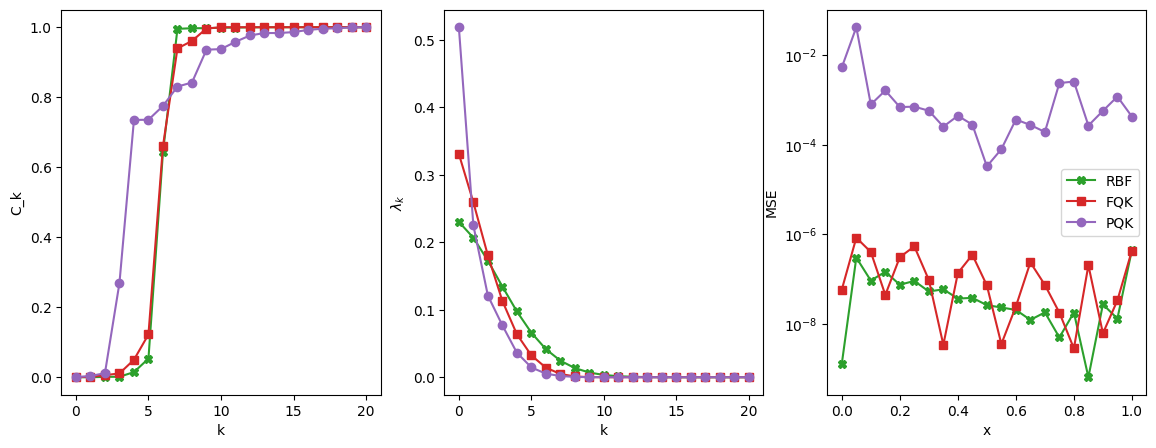

In [41]:
kernel_tensor = [RBF_kernel_list, FQK_kernel, PQK_kernel_list]
solution_list = [RBF_sol, FQK_sol, PQK_sol]
marker = ["X-", "s-", "o-"]
x_span = np.linspace(0, 1, 21)

labels = ["RBF", "FQK", "PQK"]

#two column plot axes
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
for idx_kernel, kernels in enumerate(kernel_tensor):
    K_f, K_dfdx = kernels
    eigenvalue_spectrum, eigenvectors = eigendecomposition(K_f)    

    y_train_for_analytical = f_analytical(x_span)
    if len(y_train_for_analytical.shape) == 1:
        y_train_for_analytical = y_train_for_analytical.reshape(-1, 1)

    #y_train is a column vector
    power = np.sum((eigenvectors.T @ y_train_for_analytical)**2, axis = 1)
    cumul = np.cumsum(power) / np.sum(power)


    axs[0].plot(cumul,marker[idx_kernel], label = f"{labels[idx_kernel]}", color = f"C{idx_kernel+2}")
    axs[0].set_ylabel("C_k")
    axs[0].set_xlabel("k")

    axs[1].plot(eigenvalue_spectrum, marker[idx_kernel], label = f"{labels[idx_kernel]}", color = f"C{idx_kernel+2}")
    axs[1].set_ylabel("$\lambda_k$")
    axs[1].set_xlabel("k")

    #mean squared error as a function of x

    mse = (solution_list[idx_kernel] - f_analytical(x_span))**2/ len(x_span)

    axs[2].plot(x_span, mse, marker[idx_kernel], label = f"{labels[idx_kernel]}", color = f"C{idx_kernel+2}")
    axs[2].set_ylabel("MSE")
    axs[2].set_yscale("log")
    axs[2].set_xlabel("x")




    


plt.legend()


In [ ]:
#small grid search  

num_qubits = 8

x_span = np.linspace(0, 1, 21)
sigma_list = np.linspace(0.1, 1, 10)
mse_list = np.zeros_like(sigma_list)
kernel_tensor = np.zeros((len(sigma_list), 2, len(x_span), len(x_span)))

f_initial = 1
for idx_sigma, sigma in enumerate(sigma_list):
    PQK_sol, kernel_list = PQK_solver(HardwareEfficientEmbeddingCircuit_qiskit, 21, 8, sigma)
    mse_list[idx_sigma] = np.mean((PQK_sol - f_analytical_fun(x_span))**2)
    kernel_tensor[idx_sigma] = kernel_list